Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler


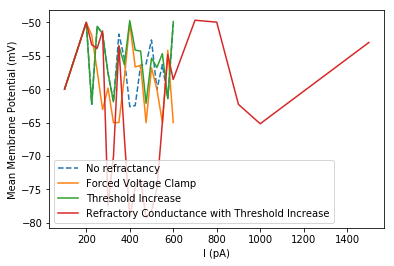

In [113]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# Descrição dos parâmetros do modelo
Cm = 0.1*nfarad # capacitância da membrana
Rm = 100*Mohm # resistência da membrana
El = -70*mV # potencial de equilíbrio da membrana
Vl = -50*mV # valor limiar de tensão de emissão de disparo
vr = -65*mV # valor de tensão de repouso após 'resetagem'
Ek = -80*mV # potencial de equilíbrio da membrana
tau_Gx = 0.2*ms
duration = 2000*ms
delta_Gx = 2*usiemens
vl_0 = -50*mV
tau_vl = 1*ms
vl_reset = 200*mV

start_scope()

#no refractancy
G = NeuronGroup(21, model = '''
dv/dt = ((El - v) / (Cm*Rm)) + (Ix/Cm) : volt
Ix : amp
''', threshold='v>Vl', reset= 'v=vr', method='euler', dt= 0.1*ms)
statemon_G = StateMonitor(G, 'v', record=0) # monitor de potencial
spikemon_G = SpikeMonitor(G) # monitor de spikes
G.Ix = [100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600]*pA

#forced voltage clamp
K = NeuronGroup(21, model = '''
dv/dt = ((El - v) / (Cm*Rm)) + (Ix/Cm) : volt (unless refractory)
Ix : amp
''', threshold='v>Vl', reset= 'v=vr', method='euler', dt= 0.1*ms, refractory = 2.5*ms)
statemon_K = StateMonitor(K, 'v', record=True) # monitor de potencial
spikemon_K = SpikeMonitor(K) # monitor de spikes
K.Ix = [100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600]*pA

#threshold increase
L = NeuronGroup(21, model='''dv/dt = ((El - v) / (Cm*Rm)) + (Ix/Cm) : volt
dvl/dt = (vl_0 - vl) / tau_vl : volt
Ix : amp''', threshold='v>vl', reset= "v=vr;vl=vl_reset", method='euler', dt= 0.1*ms)
statemon_L = StateMonitor(L, ["v","vl"], record=True) # monitor de potencial
spikemon_L = SpikeMonitor(L) # monitor de spikes
L.Ix = [100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600]*pA
L.vl = vl_0

#refractory conductance with threshold increase
M = NeuronGroup(21, model='''
dv/dt = ((El - v) / (Cm*Rm)) + ((Gx*(Ek - v)) / (Cm)) + (Ix/Cm) : volt 
dvl/dt = (vl_0 - vl) / tau_vl : volt
dGx/dt = -Gx/ tau_Gx : siemens
Ix :  amp''', threshold="v>vl", reset= "v=vr;vl=vl_reset; Gx=Gx+delta_Gx", method='euler', dt= 0.1*ms)
statemon_M = StateMonitor(M, variables='v', record=0) # monitor de potencial
spikemon_M = SpikeMonitor(M) # monitor de spikes
M.Ix = [100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600]*pA
M.Gx = 0*usiemens
M.v = El
M.vl = -50*mV

#simulation time
run(duration)

#mean potential values
mean_values_G = [mean(G.v[idx])
               for idx in range(len(G))]
mean_values_K = [mean(K.v[idx]) 
               for idx in range(len(K))]
mean_values_L = [mean(L.v[idx])
               for idx in range(len(L))]
mean_values_M = [mean(M.v[idx])
               for idx in range(len(M))]

plot(G.Ix/pA, mean_values_G/mV, '--',label = "No refractancy")
plot(K.Ix/pA, mean_values_K/mV, label = "Forced Voltage Clamp")
plot(L.Ix/pA, mean_values_L/mV, label = "Threshold Increase")
plot(M.Ix/pA, mean_values_M/mV, label = "Refractory Conductance with Threshold Increase")
xlabel('I (pA)')
ylabel('Mean Membrane Potential (mV)')
legend()
show()